# Simple Dense Neural Network / Fully connected Neural Network

In [1]:
from torchvision import datasets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

In [2]:
# Set training and test datasets
train_data = datasets.MNIST("data", train=True, download=True)
test_data = datasets.MNIST("data", train=False, download=True)

In [109]:
# Convert to numpy arrays
train_features = np.array(train_data.data) / 255.
train_labels = np.array(train_data.targets)
valid_features = np.array(test_data.data[:len(test_data.data)//2])
valid_labels = np.array(test_data.targets[:len(test_data.targets)//2])
test_features = np.array(test_data.data[len(test_data.data)//2:])
test_labels = np.array(test_data.targets[len(test_data.targets)//2:])

print(train_features.shape)
print(train_labels.shape)
print(valid_features.shape)
print(valid_labels.shape)
print(test_features.shape)
print(test_labels.shape)

5000
(60000, 28, 28)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


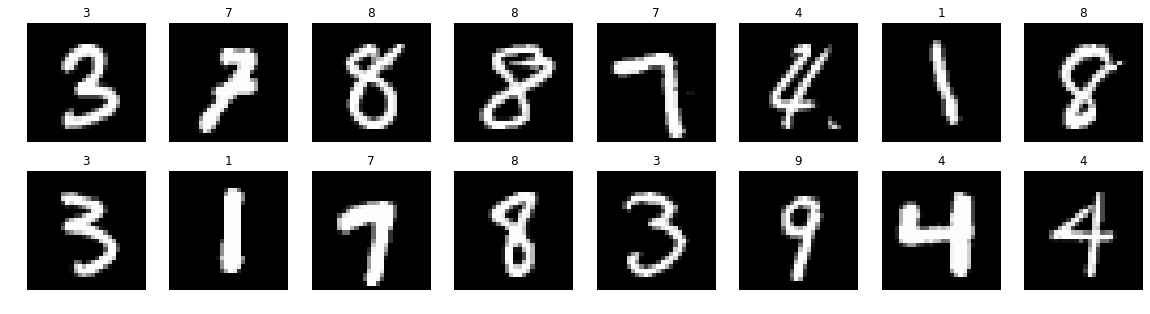

In [4]:
# show a random image from train dataset

height = 2
width = 8

f, axarr = plt.subplots(height, width, figsize=(20, 5))

for y in range(width):
    for x in range(height):
        r_idx = random.randint(0, len(train_data.data))
        axarr[x,y].set_title(int(train_data.targets[r_idx]))
        axarr[x,y].imshow(train_data.data[r_idx], cmap='gray')
        axarr[x,y].axis("off")
        
plt.show()

In [91]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def sigmoid_derived(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x, x)

def cross_entropy(x):
    x = np.exp(x)
    sums = np.sum(x, axis=1)
    return x / sums.reshape((-1, 1))

def cross_entropy_derived(x):
    return x * (1 - x)

In [6]:
x = [[0.5,0.5,0.5,-0.5],[1,2,3,4]]
print(cross_entropy(x))
np.sum(cross_entropy(x),axis=1)


[[0.29692274 0.29692274 0.29692274 0.10923177]
 [0.0320586  0.08714432 0.23688282 0.64391426]]



array([1., 1.])

## Model 1

In [55]:
class NN:
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        self.input_weights = np.random.normal(0, 1.0, (input_nodes, hidden_nodes))
        self.hidden_weights = np.random.normal(0, 1.0, (hidden_nodes, output_nodes))
    
    def predict(self, x):
        """
        x = a batch of vectors (n, features)
        """
        # FORWARD PROPAGATION
        n_count = x.shape[0]
        
        
        ## input to hidden
        h_score = np.matmul(x, self.input_weights) # (n, hidden_nodes)
        h_out = sigmoid(h_score) # (n, hidden_nodes)
        
        ## hidden to out
        output_score = np.matmul(h_out, self.hidden_weights) # (n, output_nodes)
        output = cross_entropy(output_score) # (n, output_nodes)
        
        return output
        
    def train(self, x, y, lr=0.01):
        """
        x = a batch of vectors (n, features)
        y = labels (one-hot-encoded) (n, outputs)
        """
        # FORWARD PROPAGATION
        n_count = x.shape[0]
        
        
        ## input to hidden
        h_score = np.matmul(x, self.input_weights) # (n, hidden_nodes)
        h_out = sigmoid(h_score) # (n, hidden_nodes)
        
        ## hidden to out
        output_score = np.matmul(h_out, self.hidden_weights) # (n, output_nodes)
        output = cross_entropy(output_score) # (n, output_nodes)

        error = -(1/n_count)*np.sum(np.log(output)*y) # (n, output_nodes)
        
        
        # BACKWARD PROPAGATION
        error_d = y / output
        output_d = np.zeros((n_count, self.output_nodes, self.output_nodes))
        for node_idx in range(self.output_nodes):
            for s_idx in range(self.output_nodes):
                if node_idx == s_idx:
                    output_d[:, node_idx, s_idx] = output[:,s_idx]*(1 - output[:,s_idx]) * error_d[:,s_idx]
                else:
                    output_d[:, node_idx, s_idx] = -output[:,node_idx]*output[:,s_idx] * error_d[:,s_idx]
        
        h_o_gradient = np.zeros((self.hidden_nodes, self.output_nodes)) # (n, hidden_nodes, output_nodes)
        for h_idx in range(self.hidden_nodes):
            for out_idx in range(self.output_nodes):
                h_o_gradient[h_idx, out_idx] = \
                    (np.sum(output_d[:, out_idx, :] * h_out[:, h_idx].reshape(-1,1))) / n_count
         
        # get hidden layer errors
        hidden_d = np.zeros((n_count, self.hidden_nodes, self.output_nodes, self.output_nodes))
        for h_idx in range(self.hidden_nodes):
            for out_idx in range(self.output_nodes):
                for s_idx in range(self.output_nodes):
                    hidden_d[:, h_idx, node_idx, s_idx] = \
                        output_d[:, out_idx, s_idx] * self.hidden_weights[h_idx, out_idx] * \
                        sigmoid_derived(h_out[:,h_idx])
                 
        i_h_gradient = np.zeros((self.input_nodes, self.hidden_nodes))
        for i_idx in range(self.input_nodes):
            for h_idx in range(self.hidden_nodes):
                i_h_gradient[i_idx, h_idx] = \
                    (np.sum(hidden_d[:, h_idx, -1] * x[:, i_idx].reshape(-1,1))) / n_count
        
        self.input_weights += i_h_gradient * lr
        self.hidden_weights += h_o_gradient * lr

        return error

## Model 2 - ReLu

In [111]:
class NN_relu:
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        self.input_weights = np.random.normal(0, 1.0, (input_nodes, hidden_nodes))
        self.hidden_weights = np.random.normal(0, 1.0, (hidden_nodes, output_nodes))
    
    def predict(self, x):
        """
        x = a batch of vectors (n, features)
        """
        # FORWARD PROPAGATION
        n_count = x.shape[0]
        
        
        ## input to hidden
        h_score = np.matmul(x, self.input_weights) # (n, hidden_nodes)
        h_out = relu(h_score) # (n, hidden_nodes)
        
        ## hidden to out
        output_score = np.matmul(h_out, self.hidden_weights) # (n, output_nodes)
        output = cross_entropy(output_score) # (n, output_nodes)
        
        return output
        
    def train(self, x, y, lr=0.01, train=True):
        """
        x = a batch of vectors (n, features)
        y = labels (one-hot-encoded) (n, outputs)
        """
        # FORWARD PROPAGATION
        n_count = x.shape[0]
        
        
        ## input to hidden
        h_score = np.matmul(x, self.input_weights) # (n, hidden_nodes)
        h_out = relu(h_score) # (n, hidden_nodes)
        
        ## hidden to out
        output_score = np.matmul(h_out, self.hidden_weights) # (n, output_nodes)
        output = cross_entropy(output_score) # (n, output_nodes)

        error = -(1/n_count)*np.sum(np.log(output)*y) # (n, output_nodes)
        
        if not train:
            return error
        
        # BACKWARD PROPAGATION
        error_d = y / output
        output_d = np.zeros((n_count, self.output_nodes, self.output_nodes))
        for node_idx in range(self.output_nodes):
            for s_idx in range(self.output_nodes):
                if node_idx == s_idx:
                    output_d[:, node_idx, s_idx] = output[:,s_idx]*(1 - output[:,s_idx]) * error_d[:,s_idx]
                else:
                    output_d[:, node_idx, s_idx] = -output[:,node_idx]*output[:,s_idx] * error_d[:,s_idx]
        
        h_o_gradient = np.zeros((self.hidden_nodes, self.output_nodes)) # (n, hidden_nodes, output_nodes)
        for h_idx in range(self.hidden_nodes):
            for out_idx in range(self.output_nodes):
                h_o_gradient[h_idx, out_idx] = \
                    (np.sum(output_d[:, out_idx, :] * h_out[:, h_idx].reshape(-1,1))) / n_count
         
        # get hidden layer errors
        hidden_d = np.zeros((n_count, self.hidden_nodes, self.output_nodes, self.output_nodes))
        for h_idx in range(self.hidden_nodes):
            for out_idx in range(self.output_nodes):
                for s_idx in range(self.output_nodes):
                    hidden_d[:, h_idx, node_idx, s_idx] = \
                        output_d[:, out_idx, s_idx] * self.hidden_weights[h_idx, out_idx] * \
                        h_out[:,h_idx]
                 
        i_h_gradient = np.zeros((self.input_nodes, self.hidden_nodes))
        for i_idx in range(self.input_nodes):
            for h_idx in range(self.hidden_nodes):
                i_h_gradient[i_idx, h_idx] = \
                    (np.sum(hidden_d[:, h_idx, -1] * x[:, i_idx].reshape(-1,1))) / n_count
        
        self.input_weights += i_h_gradient * lr
        self.hidden_weights += h_o_gradient * lr

        return error

## Model 3 - Added bias

In [126]:
test = np.array([[1,2,3],[4,5,6]])
new = np.ones((test.shape[0], test.shape[1]+1))
new[:,:-1] = test
print(new.shape)
print(new)

(2, 4)
[[1. 2. 3. 1.]
 [4. 5. 6. 1.]]


In [127]:
class NN_bias:
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        self.input_weights = np.random.normal(0, 1.0, (input_nodes+1, hidden_nodes))
        self.hidden_weights = np.random.normal(0, 1.0, (hidden_nodes+1, output_nodes))
    
    def predict(self, x):
        """
        x = a batch of vectors (n, features)
        """
        # FORWARD PROPAGATION
        n_count = x.shape[0]
        
        ## add bias to input layer
        new = np.ones((x.shape[0], x.shape[1]+1)) # (n, features+1)
        new[:,:-1] = x
        x = new
        
        ## input to hidden
        h_score = np.matmul(x, self.input_weights) # (n, features+1) * (features+1, h_n) = (n, hidden_nodes)
        h_out = relu(h_score) # (n, hidden_nodes)
        
        ## add bias to hidden layer
        new = np.ones((h_out.shape[0], h_out.shape[1]+1)) # (n, hidden_nodes+1)
        new[:,:-1] = h_out
        h_out = new
        
        ## hidden to out
        output_score = np.matmul(h_out, self.hidden_weights) # (n, output_nodes)
        output = cross_entropy(output_score) # (n, output_nodes)
        
        return output
        
    def train(self, x, y, lr=0.01, train=True):
        """
        x = a batch of vectors (n, features)
        y = labels (one-hot-encoded) (n, outputs)
        """
        # FORWARD PROPAGATION
        n_count = x.shape[0]
        
        ## add bias to input layer
        new = np.ones((x.shape[0], x.shape[1]+1)) # (n, features+1)
        new[:,:-1] = x
        x = new
        
        ## input to hidden
        h_score = np.matmul(x, self.input_weights) # (n, hidden_nodes)
        h_out = relu(h_score) # (n, hidden_nodes)
        
        ## add bias to hidden layer
        new = np.ones((h_out.shape[0], h_out.shape[1]+1)) # (n, hidden_nodes+1)
        new[:,:-1] = h_out
        h_out = new
        
        ## hidden to out
        output_score = np.matmul(h_out, self.hidden_weights) # (n, output_nodes)
        output = cross_entropy(output_score) # (n, output_nodes)

        error = -(1/n_count)*np.sum(np.log(output)*y) # (n, output_nodes)
        
        if not train:
            return error
        
        # BACKWARD PROPAGATION
        error_d = y / output
        output_d = np.zeros((n_count, self.output_nodes, self.output_nodes))
        for node_idx in range(self.output_nodes):
            for s_idx in range(self.output_nodes):
                if node_idx == s_idx:
                    output_d[:, node_idx, s_idx] = output[:,s_idx]*(1 - output[:,s_idx]) * error_d[:,s_idx]
                else:
                    output_d[:, node_idx, s_idx] = -output[:,node_idx]*output[:,s_idx] * error_d[:,s_idx]
        
        h_o_gradient = np.zeros((self.hidden_nodes+1, self.output_nodes)) # (n, hidden_nodes, output_nodes)
        for h_idx in range(self.hidden_nodes+1):
            for out_idx in range(self.output_nodes):
                h_o_gradient[h_idx, out_idx] = \
                    (np.sum(output_d[:, out_idx, :] * h_out[:, h_idx].reshape(-1,1))) / n_count
         
        # get hidden layer errors
        hidden_d = np.zeros((n_count, self.hidden_nodes, self.output_nodes, self.output_nodes))
        for h_idx in range(self.hidden_nodes):
            for out_idx in range(self.output_nodes):
                for s_idx in range(self.output_nodes):
                    hidden_d[:, h_idx, node_idx, s_idx] = \
                        output_d[:, out_idx, s_idx] * self.hidden_weights[h_idx, out_idx] * \
                        h_out[:,h_idx]
                 
        i_h_gradient = np.zeros((self.input_nodes+1, self.hidden_nodes))
        for i_idx in range(self.input_nodes+1):
            for h_idx in range(self.hidden_nodes):
                i_h_gradient[i_idx, h_idx] = \
                    (np.sum(hidden_d[:, h_idx, -1] * x[:, i_idx].reshape(-1,1))) / n_count
        
        self.input_weights += i_h_gradient * lr
        self.hidden_weights += h_o_gradient * lr

        return error

## Training

In [128]:
#model = NN(28**2, 40, 10)
#model = NN_relu(28**2, 40, 10)
model = NN_bias(28**2, 40, 10)

batchsize = 100
batchsize_valid = 100
epochs = 5

for epoch in range(1, epoch+1):
    # Training
    for idx in range(0, train_features.shape[0], batchsize):
        features = train_features[idx:idx+batchsize].reshape((-1, 784))
        labels = train_labels[idx:idx+batchsize]
        labels_enc = np.zeros((batchsize, 10))
        for l_idx in range(len(labels_enc)):
            labels_enc[l_idx, labels[l_idx]] = 1

        error = model.train(features, labels_enc)
        #print("{} / {}".format(idx, train_features.shape[0]) , error)
        if idx % (batchsize * 50) == 0:
            # Validation
            error_valid = 0
            for idx_v in range(0, len(valid_features), batchsize_valid):
                features_valid = valid_features[idx_v:idx+batchsize_valid].reshape((-1,784))
                labels_valid = valid_labels[idx_v:idx_v+batchsize_valid]
                labels_enc_valid = np.zeros((batchsize_valid, 10))
                error_valid += model.train(features, labels_enc, train=False)
            
            error_valid /= len(valid_features) / batchsize_valid
            
            print("Epoch: {} | Batch: {} / {} | Train Error: {:.8f} | Valid Error: {:.8f}".format(
                epoch, idx+(batchsize * 50), train_features.shape[0] , error, error_valid))


Epoch: 1 | Batch: 5000 / 60000 | Train Error: 57.01709004 | Valid Error: 53.59286020
Epoch: 1 | Batch: 10000 / 60000 | Train Error: 24.49927721 | Valid Error: 23.72398946
Epoch: 1 | Batch: 15000 / 60000 | Train Error: 18.43392048 | Valid Error: 18.01935491
Epoch: 1 | Batch: 20000 / 60000 | Train Error: 14.13415600 | Valid Error: 13.79410436
Epoch: 1 | Batch: 25000 / 60000 | Train Error: 15.34709728 | Valid Error: 14.97028199
Epoch: 1 | Batch: 30000 / 60000 | Train Error: 9.14593528 | Valid Error: 8.97243466
Epoch: 1 | Batch: 35000 / 60000 | Train Error: 9.81944135 | Valid Error: 9.69219045
Epoch: 1 | Batch: 40000 / 60000 | Train Error: 6.64580570 | Valid Error: 6.49909228
Epoch: 1 | Batch: 45000 / 60000 | Train Error: 7.92708768 | Valid Error: 7.76239782
Epoch: 1 | Batch: 50000 / 60000 | Train Error: 7.69971312 | Valid Error: 7.52696068
Epoch: 1 | Batch: 55000 / 60000 | Train Error: 6.48457317 | Valid Error: 6.31623130
Epoch: 1 | Batch: 60000 / 60000 | Train Error: 4.26530797 | Valid E

In [129]:
"""
nn_relu = 19.8 %
nn_bias = 34.3 %
"""


correct = 0

for idx in range(0,len(test_features)):
    features = test_features[idx].reshape((1,784))
    result = np.argmax(model.predict(features))
    if result == test_labels[idx]:
        correct += 1
    #print("Real: {} Prediction: {}".format(test_labels[idx], result))
print("Accuracy: {:.1f} %".format((correct/len(test_features))*100))

C:\Users\Ryan\AppData\Local\conda\conda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Accuracy: 34.3 %


In [90]:
test = np.array([1,2,3,-4,-5,-6])
np.maximum(0, test, test)
test

array([1, 2, 3, 0, 0, 0])